In [38]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Scope of the Project

Time series forecasting for blood glucose (BG) values provides valuable
information for improving the insulin management for patients with type 1
diabetes (PwT1D). Reliable BG forecasting holds the potential to improve the
automated meal announcement and possible insulin treatment (bolus dose, and
basal rate) adjustments. Further, certain events could trigger alarms to inform
the patient with respect to risks of potential future hypo- or hyperglycemia.
However, the problem complexity, the related uncertainties, as well as the
inter- and intra-patient variabilities, makes challenging the accurate
prediction of future glucose concentrations. To address these challenges, we
make benefit of recent advances in deep learning. A natural way of handling
sequential data is to use a Recurrent Neural Network (RNN) and its derivatives
such as Long-Short-Term-Memory units (LSTM) [1], Transformers [2] etc.

# Data

You will be working with recorded data from 12 different PwT1D. The data was
released in the OhiaT1DM dataset [3]. You will have access to information such
as continuous glucose monitoring (CGM), BG values obtained through
self-monitoring by the patient (finger stick), basal insulin rate, bolus
injection, the self-reported time and type of a meal, plus the patient’s
carbohydrate estimate for the meal and more. The measurements are provided at
intervals of minutes.

# Experiment

You will have to make yourself familiar with the state of the art of BG
prediction within the framework of AI. Due to missing values inside the data,
post-processing is required. You are free to choose a method to develop a robust
and patient individualized BG prediction model. We recommend to compare your
results with papers from the existing literature [4,5].

# References

Sepp Hochreiter, Jürgen Schmidhuber; Long Short-Term Memory. Neural Compute
1997; 9 (8): 1735–1780. doi: Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob
Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, & Illia Polosukhin
(2017). Attention Is All You Need. CoRR, abs/1706.03762.
￼
Tena, Felix, et al. "A Critical Review of the state-of-the-art on Deep Neural Networks for Blood
Glucose Prediction in Patients with Diabetes." arXiv preprint arXiv:2109.02178
(2021). Cui, Ran, et al. "Personalised short-term glucose prediction via
recurrent self-attention network." 2021 IEEE 34th International Symposium on
Computer-Based Medical Systems (CBMS). IEEE, 2021.

In [39]:
import os
print(os.getcwd())

/content/drive/My Drive/sophie_glucose


In [3]:
import zipfile
import os
import torch as t
import pandas as pd

#home = 'drive/MyDrive/sophie_glucose'
home = '/content/drive/MyDrive/sophie_glucose'

os.chdir(home)

extract_to = './Ohio Data'
folder_2018 = os.path.join(extract_to, 'Ohio2018_processed')


if not os.path.exists(extract_to):
  # Define the path to the zip file and the extraction target directory
  zip_path = './Ohio Data.zip'
  extract_to = './Ohio Data'

  # Create a directory to extract the files
  os.makedirs(extract_to, exist_ok=True)

  # Unzip the file
  with zipfile.ZipFile(zip_path, 'r') as zip_ref:
      zip_ref.extractall(extract_to)

  # List the contents of the extracted folder
  extracted_files = os.listdir(extract_to)
  print(extracted_files)
  # List the contents of each extracted folder
  folder_2018 = os.path.join(extract_to, 'Ohio2018_processed')
  folder_2020 = os.path.join(extract_to, 'Ohio2020_processed')

  # List the files in each folder
  files_2018 = os.listdir(folder_2018)
  files_2020 = os.listdir(folder_2020)

  # Define paths to the 'test' and 'train' subfolders for each year
  test_2018_path = os.path.join(folder_2018, 'test')
  train_2018_path = os.path.join(folder_2018, 'train')
  test_2020_path = os.path.join(folder_2020, 'test')
  train_2020_path = os.path.join(folder_2020, 'train')

  # List the files in the 'test' and 'train' subfolders for each year
  test_files_2018 = os.listdir(test_2018_path)
  train_files_2018 = os.listdir(train_2018_path)
  test_files_2020 = os.listdir(test_2020_path)
  train_files_2020 = os.listdir(train_2020_path)

  (test_files_2018, train_files_2018), (test_files_2020, train_files_2020)

  # Load one of the training files to examine
  sample_file_path = os.path.join(train_2018_path, train_files_2018[0])
  sample_data = pd.read_csv(sample_file_path)

  # Display the first few rows of the dataframe
  sample_data.tail(100)


## TODOS

- merge all datasets
- drop cbp where missing_cbg == 1.0
- fill -1 for all NaNs
- train lstm
- fill-forward for 'basal'

In [ ]:
## Custom Dataset

In [27]:
from sklearn.preprocessing import MinMaxScaler


def get_preprocessor(data_df):
    # Remove any rows with missing values for cbg
    data_df1=data_df
    # TODO: where data_df1['missing_cbg'] == 1] replace column cbg with cubic spline interpolation

    # put it in the end
    cbg=data_df1.pop('cbg')
    data_df1=data_df1.assign(cbg=cbg)

    #Drop time
    data_df1 = data_df1.drop(columns=['5minute_intervals_timestamp'])
    # Calculate the minimum of each column
    column_mins = data_df1.min()
    # Subtract a small percentile of the minimum from the minimum
    fill_values = column_mins - 0.01 * np.abs(column_mins)
    # Fill missing values with the calculated values
    data_df2 = data_df1.fillna(fill_values)
    # Initialize a scaler, then apply it to the features
    scaler = MinMaxScaler() #/ default=(0, 1)
    scaler.fit(data_df2)

    return scaler

In [28]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
from scipy.interpolate import CubicSpline

def preprocess(scaler, fill_values, data_df):
  data_df1 = data_df.copy()
 # print(f"{data_df1.columns}")
  # Identify rows where 'missing_cbg' is 1
  missing_cbg_indices = data_df1[data_df1['missing_cbg'] == 1].index

  # Perform cubic spline interpolation for 'cbg' column
  cs = CubicSpline(
    data_df1.index[~data_df1.index.isin(missing_cbg_indices)],
    data_df1.loc[~data_df1.index.isin(missing_cbg_indices), 'cbg']
  )

  data_df1.loc[missing_cbg_indices, 'cbg'] = cs(missing_cbg_indices)

  data_df1 = data_df1.drop(columns=[
      '5minute_intervals_timestamp',
      'missing_cbg'
    ]
  )

  # Move 'cbg' to the end
  cbg = data_df1.pop('cbg')
  data_df1 = data_df1.assign(cbg=cbg)

  column_mins = data_df1.min()
  # Subtract a small percentile of the minimum from the minimum
  values = data_df1.values
  """
  print("## VALUES BEFORE")
  print(values)
  """
  values = np.where(np.isnan(values), fill_values, values)
  """
  print("## FILL VALUES")
  print(fill_values)
  print(fill_values.shape)
  print("## VALUES")
  print(values)

  assert len(pd.isna(data_df2)) == 0, f'\n{data_df2[pd.isna(data_df2)]}\n{fill_values}'
  """
  assert np.isnan(values).sum() == 0, 'nope'

  data_df2 = pd.DataFrame(values, columns=data_df1.columns)
  data_df2 = pd.DataFrame(scaler.transform(data_df2), columns=data_df2.columns)

  return data_df2


def get_scaler(data_df):
    data_df1 = data_df.copy()

    #print(data_df1.columns)
    # Identify rows where 'missing_cbg' is 1
    missing_cbg_indices = data_df1[data_df1['missing_cbg'] == 1].index

    # Perform cubic spline interpolation for 'cbg' column
    cs = CubicSpline(
      data_df1.index[~data_df1.index.isin(missing_cbg_indices)],
      data_df1.loc[~data_df1.index.isin(missing_cbg_indices), 'cbg']
    )

    data_df1.loc[missing_cbg_indices, 'cbg'] = cs(missing_cbg_indices)

    # Move 'cbg' to the end
    cbg = data_df1.pop('cbg')
    data_df1 = data_df1.assign(cbg=cbg)


    # Drop time column
    data_df1 = data_df1.drop(columns=['5minute_intervals_timestamp', 'missing_cbg', 'index'])

    # Calculate the minimum of each column
    column_mins = data_df1.min()
    # Subtract a small percentile of the minimum from the minimum
    fill_values = column_mins - 0.01 * np.abs(column_mins)
    # Fill missing values with the calculated values
    data_df2 = data_df1.fillna(fill_values)

    # Initialize a scaler, then apply it to the features
    scaler = MinMaxScaler()  # default=(0, 1)
    scaler.fit(data_df2)

    assert np.isnan(fill_values.values).sum() == 0, 'oh nooo'

    return scaler, fill_values


In [30]:
import matplotlib.pyplot as plt

def plot_seqs(sequence1, sequence2, sequence3):
  # Replace these with your actual sequences


  # Create a figure and a set of subplots
  fig, axs = plt.subplots(3, 1, figsize=(10, 8))

  # Plot each sequence in a separate subplot
  axs[0].plot(sequence1)
  axs[0].set_title('Sample 1')

  axs[1].plot(sequence2)
  axs[1].set_title('Sample 2')

  axs[2].plot(sequence3)
  axs[2].set_title('Sample 3')

  # Adjust layout for better display
  plt.tight_layout()

  # Show the plot
  plt.show()


In [31]:
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import os
import torch as t


path=os.getcwd()



class OhioT1DMDataset(Dataset):
    def __init__(self, data_dirs, seq_length):
        self.seq_length = seq_length

        # Initialize an empty DataFrame
        merged_data = pd.DataFrame()
        dataframes = []
        # Load and merge data from all directories provided
        for data_dir in data_dirs:
            for subdir, dirs, files in os.walk(data_dir):
                for file in files:
                    file_path = os.path.join(subdir, file)
                    # Assuming the data is in a CSV format
                    data_df = pd.read_csv(file_path)
                    # Append the data to the merged_data DataFrame
                    merged_data = pd.concat([merged_data, data_df])
                    dataframes.append(data_df)

        merged_data.reset_index(inplace=True)
        #print(merged_data.columns)
        # Apply the preprocess function to the merged data
        scaler, fill_values = get_scaler(merged_data)
        self.scaler = scaler
        self.preprocessed_dfs = [preprocess(scaler, fill_values, df) for df in dataframes]

        # Convert the DataFrame to a PyTorch tensor
        self.data = [t.tensor(df.values, dtype=t.float32) for df in self.preprocessed_dfs]

    def __len__(self):
        # Return the total number of sequences available
        return sum(len(data) - self.seq_length + 1 for data in self.data)

    def __getitem__(self, index):
        # Find which data point this index is referring to
        data_idx = 0
        while index >= len(self.data[data_idx]) - self.seq_length + 1:
            index -= len(self.data[data_idx]) - self.seq_length + 1
            data_idx += 1

        # Extract the sequence
        sequence = self.data[data_idx][index:index+self.seq_length]
        # Split the sequence into inputs and target
        inputs = sequence[:-1,:]  # All but the last element
        target = sequence[-1,:]  # FIXME it was [-1, -1] before. # Only the last element

        return inputs, target
# Adjust the create_dataloader function to accept a list of directories
def create_dataloader(data_dirs, seq_length, batch_size):
    # Instantiate the custom dataset
    dataset = OhioT1DMDataset(data_dirs, seq_length)
    # Create a DataLoader
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True);

    def unscale(data):
      data = data.squeeze(0)
      df = pd.DataFrame(data, columns=dataset.preprocessed_dfs[0].columns)
      unscaled = dataset.scaler.inverse_transform(df)
      return t.tensor(unscaled)[None]

    dataloader.__dict__['unscale'] = unscale
    return dataloader

# Example usage of the function to create a DataLoader for the combined train data
train_data_dirs = [
    f"{path}/Ohio Data/Ohio2018_processed/train",
    f"{path}/Ohio Data/Ohio2020_processed/train"
]
test_data_dirs = [
    f"{path}/Ohio Data/Ohio2018_processed/test",
    f"{path}/Ohio Data/Ohio2020_processed/test"
]

## LSTM

In [32]:

import torch.nn as nn


class SimpleLSTM(nn.Module):
  def __init__(
      self,
      input_size: int,
      hidden_size:int,
      num_layers:int,
      output_size:int
    ):
    super().__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.batch_norm = nn.BatchNorm1d(input_size)
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
    self.fc = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    # Initialize hidden and cell states
    h0 = t.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
    c0 = t.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

    # Forward propagate LSTM
    out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)

    # Decode the hidden state of the last time step
    out = self.fc(out[:, -1, :])
    return out

In [13]:
import torch as t
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        num_layers: int,
        output_size: int
    ):
        super().__init__()
        self.hidden_size = hidden_size

        # Define a simple CNN architecture with batch normalization
        self.cnn_layers = nn.Sequential(
            nn.Conv1d(input_size, hidden_size, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_size),  # Batch normalization layer
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            *[
                nn.Sequential(
                    nn.Conv1d(hidden_size, hidden_size, kernel_size=3, padding=1),
                    nn.BatchNorm1d(hidden_size),  # Batch normalization layer
                    nn.ReLU(),
                    nn.MaxPool1d(kernel_size=2)
                ) for _ in range(num_layers - 1)
            ]
        )

        # Calculate the size of the features after the convolutions
        self.feature_size = self._get_conv_output_size(input_size, num_layers)

        # Define the output layer
        self.fc = nn.Linear(30, output_size)

    def _get_conv_output_size(self, input_size, num_layers):
        # Dummy data to calculate feature size
        dummy_data = t.zeros(1, input_size, input_size)
        output = self.cnn_layers(dummy_data)
        return output.size(-1)

    def forward(self, x):
        # Rearrange input for Conv1d (batch_size, channels, seq_length)
        x = x.transpose(1, 2)

        # Forward pass through CNN layers
        out = self.cnn_layers(x)

        # Flatten the output for the fully connected layer
        out = out.view(out.size(0), -1)

        # Pass through the fully connected layer
        out = self.fc(out)
        return out


## Training Loop

In [52]:
import torch.optim as optim
import matplotlib.pyplot as plt
import torch as t
from torch import nn
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('runs/example_project')

def plot_losses(train_losses, test_losses):
    # Create a figure and a set of subplots
    fig, axs = plt.subplots(2, 1, sharex=True)

    # Plot for train losses
    axs[0].plot(t.arange(len(train_losses[20:])), train_losses[20:], label='train')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].set_title('Train Loss')

    # Plot for test losses
    axs[1].plot(t.arange(len(test_losses[20:])), test_losses[20:], label='test')
    axs[1].set_ylabel('Loss')
    axs[1].legend()
    axs[1].set_title('Test Loss')

    # Set common x label
    plt.xlabel('Epoch')
    plt.show()

def train(
  net_class:type,
  input_size:int,
  hidden_size:int,
  num_layers:int,
  output_size:int,
  lr:float = 0.01,
  num_epochs:int=100,
  batch_size:int=256
):
  # We use a default batch size of 64 as an example
  train_dataloader = create_dataloader(
      data_dirs=train_data_dirs,
      seq_length=25,  # Example sequence length
      batch_size=batch_size
  )
  test_dataloader = create_dataloader(
      data_dirs=train_data_dirs,
      seq_length=25,  # Example sequence length
      batch_size=batch_size
  )


  model = net_class(input_size, hidden_size, num_layers, output_size)
  print(model)

  # Define loss function and optimizer
  criterion = nn.MSELoss()  # for regression tasks; use nn.CrossEntropyLoss for classification tasks
  optimizer = optim.Adam(model.parameters(), lr=lr)

  train_losses: list[float] = []
  test_losses: list[float] = []

  best_validation_loss = float('inf')
  best_model_dict = None

  # Training loop
  for epoch in range(num_epochs):

      epoch_train_losses = []
      model.train()  # Set model to training mode
      for inputs, targets in train_dataloader:
          # Zero the parameter gradients
          optimizer.zero_grad()

          # Forward pass
          outputs = model(inputs)
          loss = criterion(outputs, targets)

          # Backward pass and optimize
          loss.backward()
          optimizer.step()
          epoch_train_losses.append(loss)

      if epoch == 80:
        lr /= 10

      # Validation phase
      model.eval()  # Set model to evaluation mode
      epoch_test_losses = []
      with t.no_grad():  # No gradients required for validation
          for inputs, targets in test_dataloader:
              outputs = model(inputs)
              # print(f'{outputs.shape=}')
              # print(f'{targets.shape=}')
              loss = criterion(outputs[:,-1], targets[:, -1])
              epoch_test_losses.append(loss.item())

      # Calculate average validation loss
      # validation_loss /= len(validation_data_loader)
      # Print statistics
      #print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {validation_loss:.4f}')
      mean_train_loss = t.mean(t.tensor(epoch_train_losses))
      mean_test_loss = t.mean(t.tensor(epoch_test_losses))
      print(f'Epoch {epoch+1}/{num_epochs}\tTrain MSE: {mean_train_loss.item():.9f}\tTest MSE {mean_test_loss.item():.9f}')
      # Store the loss value
      train_losses.append(mean_train_loss.item())
      test_losses.append(mean_test_loss.item())

      writer.add_scalar('train loss', mean_train_loss, epoch)
      writer.add_scalar('test loss', mean_test_loss, epoch)

      current_validation_loss = mean_test_loss.item()
      if current_validation_loss < best_validation_loss:
          best_validation_loss = current_validation_loss
          best_model_dict = model.state_dict()  # Save the model parameters


  # Plot the loss values
  plot_losses(train_losses, test_losses)
  t.save(best_model_dict, 'best_model.pth')

  assert best_model_dict is not None
  model.load_state_dict(best_model_dict)

  t.save(model.state_dict(), 'simple_lstm_model.pth')

  return train_losses, test_losses, model

  # Save the model checkpoint
  #print('Training complete')



<module 'zipfile' from '/usr/lib/python3.10/zipfile.py'>
<module 'pkg_resources' from '/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py'>
<module 'types' from '/usr/lib/python3.10/types.py'>
<module 'sys' (built-in)>
<module 'os' from '/usr/lib/python3.10/os.py'>


SimpleLSTM(
  (batch_norm): BatchNorm1d(7, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lstm): LSTM(7, 5, batch_first=True)
  (fc): Linear(in_features=5, out_features=7, bias=True)
)
Epoch 1/100	Train MSE: 0.077116281	Test MSE 0.002641472
Epoch 2/100	Train MSE: 0.007093132	Test MSE 0.003257127
Epoch 3/100	Train MSE: 0.003364363	Test MSE 0.003297261
Epoch 4/100	Train MSE: 0.002098183	Test MSE 0.002103049
Epoch 5/100	Train MSE: 0.001739406	Test MSE 0.001689479
Epoch 6/100	Train MSE: 0.001611483	Test MSE 0.001539732
Epoch 7/100	Train MSE: 0.001544013	Test MSE 0.001471361
Epoch 8/100	Train MSE: 0.001495925	Test MSE 0.001420304
Epoch 9/100	Train MSE: 0.001455880	Test MSE 0.001359974
Epoch 10/100	Train MSE: 0.001416252	Test MSE 0.001282487
Epoch 11/100	Train MSE: 0.001368484	Test MSE 0.001168268
Epoch 12/100	Train MSE: 0.001310914	Test MSE 0.000987182
Epoch 13/100	Train MSE: 0.001241370	Test MSE 0.000743636
Epoch 14/100	Train MSE: 0.001178618	Test MSE 0.000467796
Epoch 

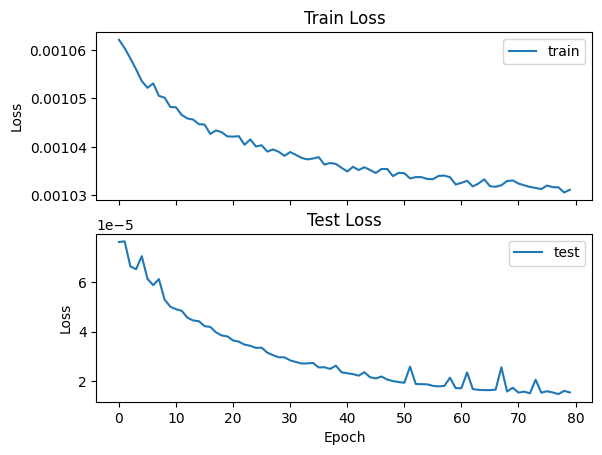

In [40]:
train_losses, test_losses, lstm_model = train(
  net_class=SimpleLSTM,
  input_size=7,
  hidden_size=5,
  num_layers=1,
  output_size=7,
  lr=0.001,
  batch_size=500,
  num_epochs=150
)

In [ ]:
train_losses, test_losses, cnn_model = train(
  net_class=SimpleCNN,
  input_size=7,
  hidden_size=5,
  num_layers=2,
  output_size=7,
  lr=0.001,
  batch_size=500,
  num_epochs=100
)

In [41]:
import matplotlib.pyplot as plt


def get_prediction_ahead(model: t.nn.Module, input_seq:t.Tensor, n_steps:int):
  model.eval()
  with t.no_grad():
    cur_input_seq = input_seq.clone()
    for i in range(n_steps):
      next_value = model(cur_input_seq)[:, None]
      cur_input_seq = t.cat([cur_input_seq[:, 1:], next_value], dim=1)
  model.train()
  return cur_input_seq[:, -n_steps:]


def plot_predictions(model: nn.Module,n_steps_ahead:int=6):
  train_seq_len=24
  dataloader = create_dataloader(
      data_dirs=test_data_dirs,
      seq_length=train_seq_len + 1 + n_steps_ahead,  # Example sequence length
      batch_size=1
  )
  sample = next(iter(dataloader))
  sample_context = sample[0][:, :24]
  sample_ahead = sample[0][:, 24:]
  print(f"{sample_context.shape=}")
  print(f"{sample_ahead.shape=}")
  prediction = get_prediction_ahead(model, sample_context, n_steps_ahead)
  print(prediction.shape)
  prediction = prediction
  print(f"{prediction.shape=}")

  plt.clf()
  plt.close()
  total_timesteps = t.arange(train_seq_len + n_steps_ahead)
  plt.plot(total_timesteps[:train_seq_len], dataloader.unscale(sample_context).squeeze()[:, -1], label='context')
  plt.plot(total_timesteps[-n_steps_ahead:], dataloader.unscale(sample_ahead).squeeze()[:, -1], label='true')
  plt.plot(total_timesteps[-n_steps_ahead:], dataloader.unscale(prediction).squeeze()[:, -1], label='pred')
  plt.legend()
  plt.show()

sample_context.shape=torch.Size([1, 24, 7])
sample_ahead.shape=torch.Size([1, 6, 7])
torch.Size([1, 6, 7])
prediction.shape=torch.Size([1, 6, 7])


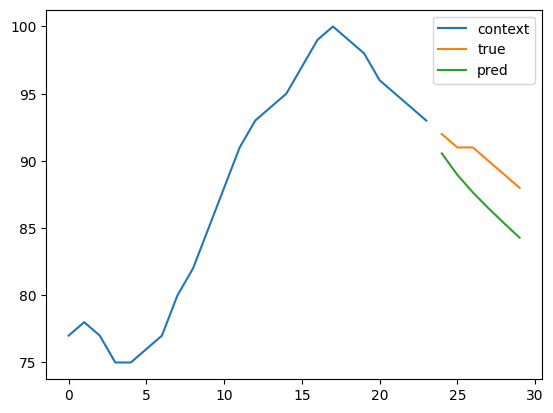

sample_context.shape=torch.Size([1, 24, 7])
sample_ahead.shape=torch.Size([1, 6, 7])
torch.Size([1, 6, 7])
prediction.shape=torch.Size([1, 6, 7])


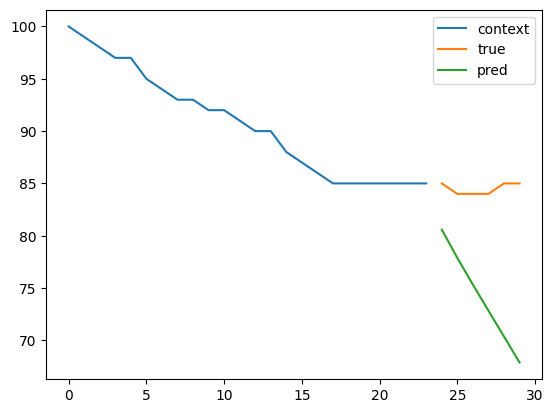

sample_context.shape=torch.Size([1, 24, 7])
sample_ahead.shape=torch.Size([1, 6, 7])
torch.Size([1, 6, 7])
prediction.shape=torch.Size([1, 6, 7])


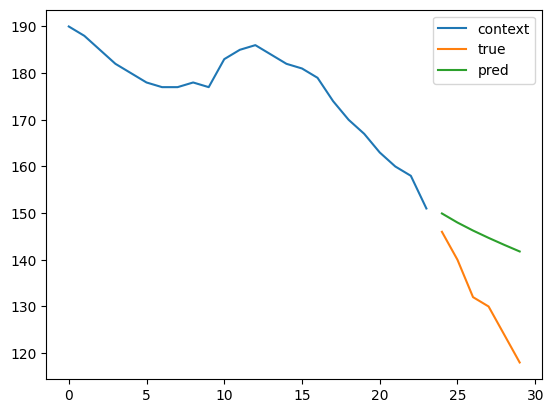

sample_context.shape=torch.Size([1, 24, 7])
sample_ahead.shape=torch.Size([1, 6, 7])
torch.Size([1, 6, 7])
prediction.shape=torch.Size([1, 6, 7])


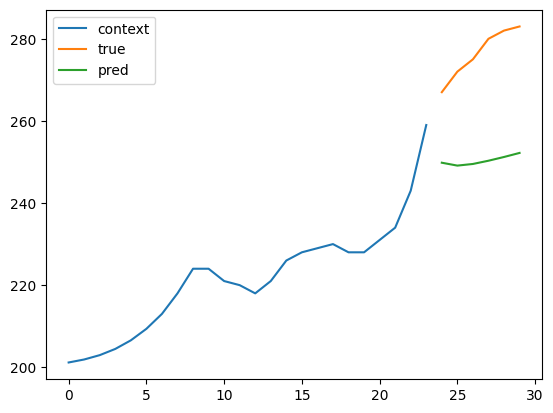

sample_context.shape=torch.Size([1, 24, 7])
sample_ahead.shape=torch.Size([1, 6, 7])
torch.Size([1, 6, 7])
prediction.shape=torch.Size([1, 6, 7])


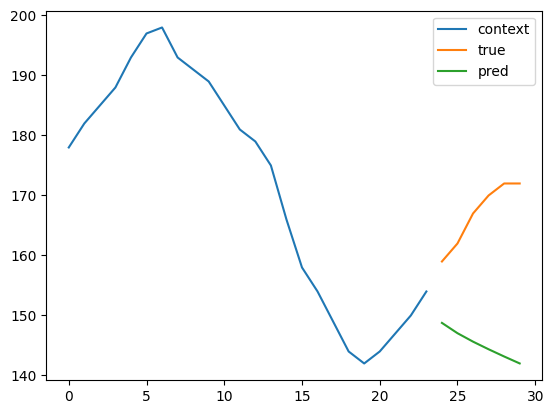

sample_context.shape=torch.Size([1, 24, 7])
sample_ahead.shape=torch.Size([1, 6, 7])
torch.Size([1, 6, 7])
prediction.shape=torch.Size([1, 6, 7])


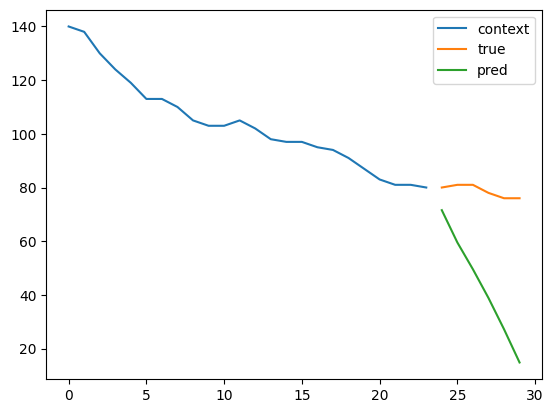

sample_context.shape=torch.Size([1, 24, 7])
sample_ahead.shape=torch.Size([1, 6, 7])
torch.Size([1, 6, 7])
prediction.shape=torch.Size([1, 6, 7])


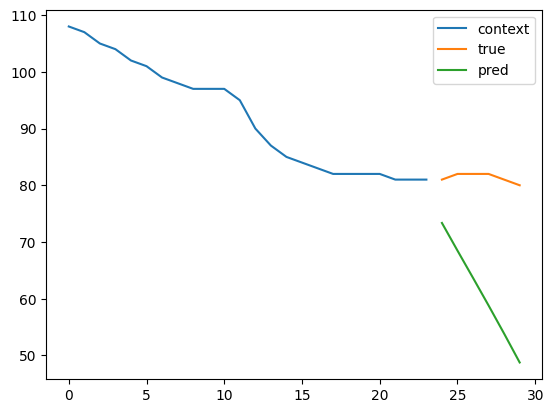

sample_context.shape=torch.Size([1, 24, 7])
sample_ahead.shape=torch.Size([1, 6, 7])
torch.Size([1, 6, 7])
prediction.shape=torch.Size([1, 6, 7])


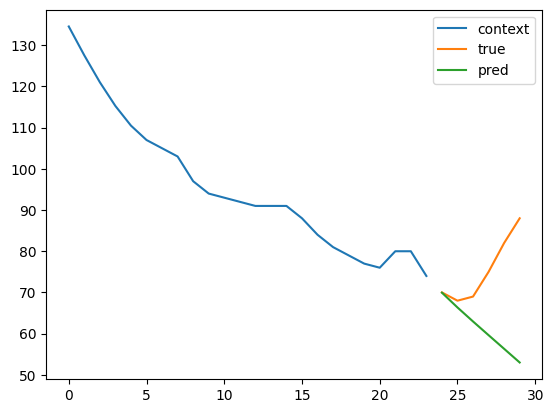

In [42]:
# FIXME: replace with lstm_model or conv_model
plot_predictions(lstm_model,6)
plot_predictions(lstm_model,6)
plot_predictions(lstm_model,6)
plot_predictions(lstm_model,6)
plot_predictions(lstm_model,6)
plot_predictions(lstm_model,6)
plot_predictions(lstm_model,6)
plot_predictions(lstm_model,6)

In [43]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import torch.nn as nn

def compute_metrics(model: nn.Module):
    n_steps_ahead = 6
    train_seq_len = 24

    dataloader = create_dataloader(
        data_dirs=test_data_dirs,
        seq_length=train_seq_len + 1 + n_steps_ahead,  # Example sequence length
        batch_size=1
    )

    # Initialize metrics
    mse_values = []
    mae_values = []
    rmse_values = []
    r2_values = []
    cc_values = []  # Correlation Coefficient
    fit_values = []  # Fit Index
    mard_values = []  # Mean Absolute Relative Difference

    for sample in dataloader:
        sample_context = sample[0][:, :24]
        sample_ahead = sample[0][:, 24:]

        prediction = get_prediction_ahead(model, sample_context, n_steps_ahead)
        prediction = dataloader.unscale(prediction).squeeze()[:, -1]
        sample_ahead = dataloader.unscale(sample_ahead).squeeze()[:, -1]

        # Update metrics
        mse = mean_squared_error(sample_ahead, prediction)
        mse_values.append(mse)

        rmse = np.sqrt(mse)
        rmse_values.append(rmse)

        mae = mean_absolute_error(sample_ahead, prediction)
        mae_values.append(mae)

        #r2 = r2_score(sample_ahead, prediction)
        #r2_values.append(r2)

        #cc = np.corrcoef(sample_ahead, prediction)
        #cc_values.append(cc[0, 1])


        #numerator =  (abs(prediction - sample_ahead.mean()).sum())/len(sample_ahead)
        #numerator = (t.abs(prediction - t.mean(sample_ahead)).sum())/len(sample_ahead)  # Sum of squares of differences
        #denominator = (abs(sample_ahead - sample_ahead.mean()).sum())/len(sample_ahead)
        #denominator = (t.abs(sample_ahead - t.mean(sample_ahead)).sum())/len(sample_ahead)  # Total sum of squares
        #fit = 1 - (numerator / denominator) if denominator != 0 else 0  # Handle division by zero
        #fit_values.append(fit)

        relative_diff = (sample_ahead - prediction)
        mard = t.mean(t.abs(relative_diff)/sample_ahead)
        mard_values.append(mard)

    # Aggregate metrics
    metrics = {
        'MSE': np.mean(mse_values),
        'MSE_sd': np.std(mse_values, ddof=1) / np.sqrt(len(mse_values)),
        'RMSE': np.mean(rmse_values),
        'RMSE_sd': np.std(rmse_values, ddof=1) / np.sqrt(len(rmse_values)),
        'MAE': np.mean(mae_values),
        'MAE_sd': np.std(mae_values, ddof=1) / np.sqrt(len(mae_values)),
        #'R2': np.mean(r2_values),
        #'CC': np.mean(cc_values),
        #'FIT': np.mean(fit_values),
        'MARD': np.mean(mard_values),
        'MARD_sd': np.std(mae_values, ddof=1) / np.sqrt(len(mae_values)),
    }

    return metrics


In [44]:
# lstm_model or conv_model
print(compute_metrics(lstm_model))

KeyboardInterrupt: ignored

In [57]:
import pkg_resources

# Manually specify the libraries you've used in your notebook
libraries_used = ['scipy','numpy', 'pandas', 'torch', 'matplotlib', 'scikit-learn']

# List to hold strings for each package and its version
packages_versions_list = ["dependencies:"]

# Iterate over the specified libraries
for library in libraries_used:
    try:
        # Get the version of the package
        version = pkg_resources.get_distribution(library).version
        packages_versions_list.append(f"{library}=={version}")
    except pkg_resources.DistributionNotFound:
        # If a package isn't found, we can skip it or print a message
        print(f"The library {library} is not installed.")

# Write the package versions to a file
with open('/content/requirements.yaml', 'w') as f:
    for item in packages_versions_list:
        f.write(f"  - {item}\n" if item != "dependencies:" else f"{item}\n")

# Print out the contents of the file to the screen
!cat /content/requirements.yaml



dependencies:
  - scipy==1.11.3
  - numpy==1.23.5
  - pandas==1.5.3
  - torch==2.1.0+cu118
  - matplotlib==3.7.1
  - scikit-learn==1.2.2
